In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer el archivo CSV
file_path = "Codefest csv.csv"
data = pd.read_csv(file_path, delimiter=';', skiprows=52)

In [4]:

data = data[['Frequency [Hz]', 'Magnitude [dBm]']]

data['Frequency [Hz]'] = pd.to_numeric(data['Frequency [Hz]'].str.replace(',', '.', regex=False))
data['Magnitude [dBm]'] = pd.to_numeric(data['Magnitude [dBm]'].str.replace(',', '.', regex=False))
frequency_data = data['Frequency [Hz]']
power_data = data['Magnitude [dBm]']

# Cálculos para caracterizar la señal
frecuencia_central = frequency_data.mean()  # Frecuencia Central como promedio
amplitud_maxima = power_data.max()           # Amplitud máxima
potencia_maxima = np.power(amplitud_maxima, 3)


In [5]:
threshold = potencia_maxima / 2
bw_indices = np.where(power_data >= threshold)[0]
ancho_de_banda = frequency_data[bw_indices[-1]] - frequency_data[bw_indices[0]] if len(bw_indices) > 1 else 0

In [6]:
print(f"Frecuencia Central: {frecuencia_central:.2f} Hz")
print(f"Amplitud Máxima: {amplitud_maxima:.2f}")
print(f"Potencia Máxima: {potencia_maxima:.2f}")
print(f"Ancho de Banda: {ancho_de_banda:.2f} Hz")

Frecuencia Central: 435000000.00 Hz
Amplitud Máxima: -51.30
Potencia Máxima: -135018.43
Ancho de Banda: 30000000.00 Hz


In [11]:
fft_result = np.fft.fft(power_data)
fft_magnitude = np.abs(fft_result)  # Magnitud de la FFT
fft_frequency = np.fft.fftfreq(len(power_data), frequency_data[1] - frequency_data[0])

# Definir el rango de la señal principal (por ejemplo, los picos mayores)
# Ajusta el rango de frecuencia según lo que veas en la gráfica
signal_band = (fft_frequency > 400) & (fft_frequency < 500) #Frecuencia establecida para la detección de señales satelitales

# Estimar la potencia de la señal: usando la potencia máxima o RMS dentro de la banda de la señal
if np.any(signal_band):  # Check if any values in signal_band are True
    signal_power_rms = np.sqrt(np.mean(np.square(fft_magnitude[signal_band])))
else:
    signal_power_rms = fft_magnitude.max() #Si no se detecta señal, se toma el valor máximo de la magnitud de la FFT

# Estimar la potencia del ruido: usando la RMS fuera de la banda de la señal
noise_band = ~signal_band
noise_power_rms = np.sqrt(np.mean(np.square(fft_magnitude[noise_band])))

# Calcular la Relación Señal-Ruido (SNR) en decibelios (dB)
snr_db = 10 * np.log10(signal_power_rms / noise_power_rms)

# Mostrar resultados
print(f"Potencia de la Señal (RMS): {signal_power_rms:.2f}")
print(f"Potencia del Ruido (RMS): {noise_power_rms:.2f}")
print(f"Relación Señal-Ruido (SNR): {snr_db:.2f} dB")

Potencia de la Señal (RMS): 55015.21
Potencia del Ruido (RMS): 2196.81
Relación Señal-Ruido (SNR): 13.99 dB


In [10]:
# Describir cualitativamente la forma de la señal
if ancho_de_banda < 10 and snr_db > 20: # El ancho de banda y la SNR fueron establecidos en un rango bajo buscando separar señales satelitales estrechas
    forma = "Pico estrecho y dominante"
elif ancho_de_banda > 10 and snr_db > 20:  
    forma = "Ancha y clara"
elif snr_db < 10:
    forma = "Señal ruidosa"
elif len(np.where(fft_magnitude[signal_band] > noise_power_rms * 2)[0]) > 1:
    forma = "Múltiples picos"
else:
    forma = "Difusa o indefinida"

# Mostrar los resultados
print(f"Forma de la Señal: {forma}")


Forma de la Señal: Difusa o indefinida


Frecuencias Espurias Detectadas: [ 0.00000000e+00  3.32805071e-08  6.65610143e-08  9.98415214e-08
  1.33122029e-07  1.66402536e-07  1.99683043e-07  2.32963550e-07
  2.66244057e-07  2.99524564e-07  3.32805071e-07  3.66085578e-07
  3.99366086e-07  4.32646593e-07  4.65927100e-07  4.99207607e-07
  5.32488114e-07  5.65768621e-07  5.99049128e-07  6.32329636e-07
  6.65610143e-07  6.98890650e-07  7.32171157e-07  7.65451664e-07
  7.98732171e-07  8.32012678e-07  8.65293185e-07  8.98573693e-07
  9.31854200e-07  9.65134707e-07  9.98415214e-07  1.03169572e-06
  1.06497623e-06  1.09825674e-06  1.13153724e-06  1.16481775e-06
  1.19809826e-06  1.23137876e-06  1.26465927e-06  1.29793978e-06
  1.33122029e-06  1.36450079e-06  1.39778130e-06  1.43106181e-06
  1.46434231e-06  1.49762282e-06  1.53090333e-06  1.56418384e-06
  1.59746434e-06  1.63074485e-06  1.66402536e-06  1.69730586e-06
  1.73058637e-06  1.76386688e-06  1.79714739e-06  1.83042789e-06
  1.86370840e-06  1.89698891e-06  1.93026941e-06  1.96354

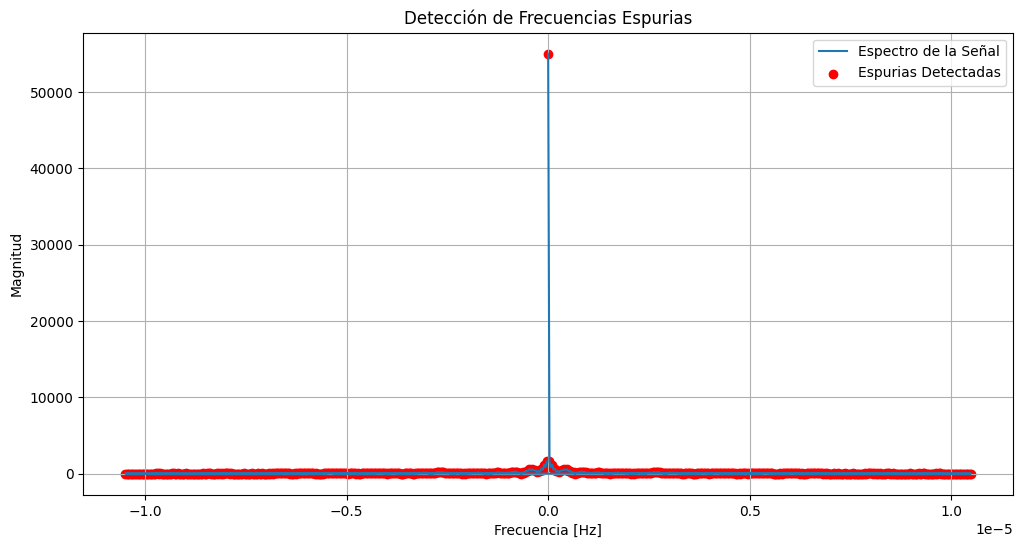

In [32]:
# Definir umbral para detectar espurias (por ejemplo, 20% de la potencia de la señal principal)
umbral_espurias = 0.2 * signal_power_rms #Se establece un umbral del 20% de la potencia de la señal principal teniendo como referencia la señal principal estudiada

# Identificar las frecuencias que superan el umbral fuera de la banda principal
espurias_indices = np.where((fft_magnitude > umbral_espurias) & (~signal_band))[0] #Se buscan las frecuencias que superan el umbral y que no están en la banda principal
espurias_frecuencias = fft_frequency[espurias_indices] 


# Mostrar frecuencias espurias detectadas
print(f"Frecuencias Espurias Detectadas: {espurias_frecuencias}")

# Mostrar la cantidad y ubicación de espurias
if len(espurias_frecuencias) == 0:
    print("No se detectaron frecuencias espurias significativas.")
else:
    print(f"Se detectaron {len(espurias_frecuencias)} frecuencias espurias.")

# Opcional: graficar y marcar las frecuencias espurias
plt.figure(figsize=(12, 6))
plt.plot(fft_frequency, fft_magnitude, label='Espectro de la Señal')
plt.scatter(espurias_frecuencias, fft_magnitude[espurias_indices], color='red', label='Espurias Detectadas')
plt.title('Detección de Frecuencias Espurias')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud')
plt.grid()
plt.legend()
plt.show()

In [34]:
# Definición de variables
frecuencia_fundamental = 435e6  # Frecuencia fundamental en Hz (435 MHz) - Se estableció este valor como referencia ya que fue un pico de la señal proveniente de un satélite
marcadores = {
    1: {"frecuencia": 433.2380952e6, "potencia": -51.3},  # Hz y dBm
    2: {"frecuencia": 400e6, "potencia": None},
    3: {"frecuencia": 450e6, "potencia": -91.76},
    4: {"frecuencia": 430e6, "potencia": -87.1},
    5: {"frecuencia": 440e6, "potencia": -90.65},
}

# Número de armónicas a calcular
num_armonicas = 5 

# Calcular frecuencias armónicas
frecuencias_armonicas = [n * frecuencia_fundamental for n in range(1, num_armonicas + 1)]

# Imprimir las frecuencias armónicas calculadas
print("Frecuencias armónicas calculadas:")
for i, f_armonica in enumerate(frecuencias_armonicas, 1):
    print(f"{i}ª armónica: {f_armonica / 1e6} MHz")

# Comparar armónicas calculadas con marcadores medidos
print("\nComparación con frecuencias medidas:")
for i, f_armonica in enumerate(frecuencias_armonicas, 1):
    dentro_de_marcadores = False
    for marcador, datos in marcadores.items():
        f_marcador = data['Frequency [Hz]']
        potencia = data['Magnitude [dBm]']
        # Verificar si la frecuencia del marcador está cerca de la armónica (tolerancia de ±5 MHz)
        if abs(f_marcador - f_armonica).any() <= 5e6:
            dentro_de_marcadores = True
            print(f"{i}ª armónica ({f_armonica / 1e6} MHz) está cerca del marcador {marcador} ({f_marcador / 1e6} MHz) con potencia {potencia} dBm.")
            break
    if not dentro_de_marcadores:
        print(f"{i}ª armónica ({f_armonica / 1e6} MHz) no se encuentra cerca de ningún marcador medido.")

Frecuencias armónicas calculadas:
1ª armónica: 435.0 MHz
2ª armónica: 870.0 MHz
3ª armónica: 1305.0 MHz
4ª armónica: 1740.0 MHz
5ª armónica: 2175.0 MHz

Comparación con frecuencias medidas:
1ª armónica (435.0 MHz) está cerca del marcador 1 (0      420.000000
1      420.047619
2      420.095238
3      420.142857
4      420.190476
          ...    
626    449.809524
627    449.857143
628    449.904762
629    449.952381
630    450.000000
Name: Frequency [Hz], Length: 631, dtype: float64 MHz) con potencia 0     -83.040863
1     -83.040863
2     -85.464035
3     -84.121216
4     -84.871971
         ...    
626   -91.439560
627   -91.531113
628   -94.991913
629   -91.726433
630   -91.756950
Name: Magnitude [dBm], Length: 631, dtype: float64 dBm.
2ª armónica (870.0 MHz) está cerca del marcador 1 (0      420.000000
1      420.047619
2      420.095238
3      420.142857
4      420.190476
          ...    
626    449.809524
627    449.857143
628    449.904762
629    449.952381
630    450.000000
N

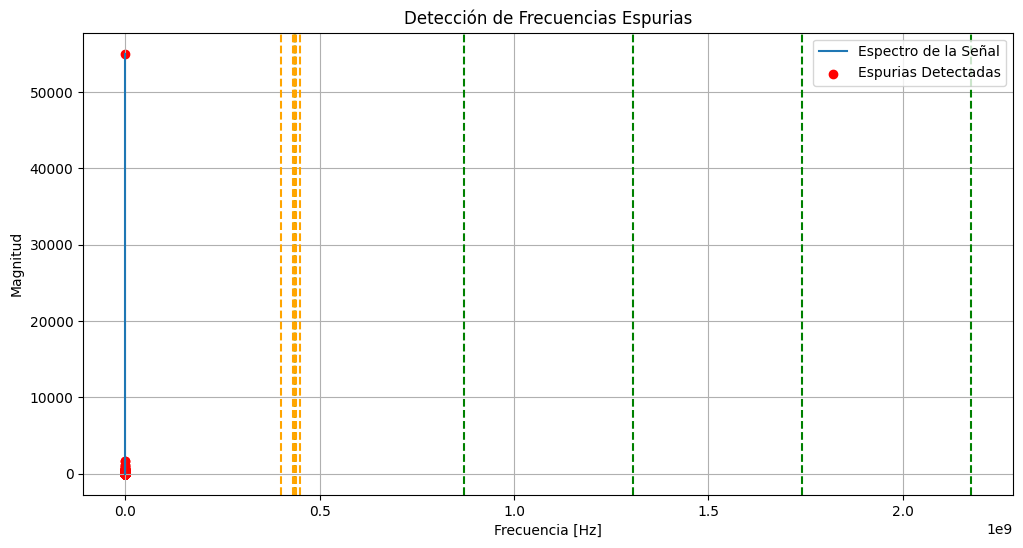

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(fft_frequency, fft_magnitude, label='Espectro de la Señal')
plt.scatter(espurias_frecuencias, fft_magnitude[espurias_indices], color='red', label='Espurias Detectadas')
plt.title('Detección de Frecuencias Espurias')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud')
plt.grid()
plt.legend()

# Graficar las frecuencias armónicas calculadas
for i, f_armonica in enumerate(frecuencias_armonicas, 1):
  plt.axvline(x=f_armonica, color='green', linestyle='--', label=f'{i}ª Armónica' if i == 1 else None)


# Graficar las frecuencias de los marcadores
for marcador, datos in marcadores.items():
  plt.axvline(x=datos["frecuencia"], color='orange', linestyle='--', label=f'Marcadores' if marcador == 1 else None)


plt.show()


In [36]:
# Definir el umbral para identificar interferencias
threshold = np.mean(fft_magnitude) + 3 * np.std(fft_magnitude)  # Ejemplo: promedio + 3 desviaciones estándar, este umbral fue definido para el caso de estudio

# Identificar picos que superen el umbral
interference_indices = np.where(fft_magnitude > threshold)[0]
interference_frequencies = fft_frequency[interference_indices]
interference_magnitudes = fft_magnitude[interference_indices]

# Mostrar las frecuencias e intensidades de las interferencias detectadas
print("Interferencias Detectadas:")
for freq, mag in zip(interference_frequencies, interference_magnitudes):
    if freq >= 0:  # Solo mostrar frecuencias positivas
        print(f"Frecuencia: {freq:.2f} Hz, Magnitud: {mag:.2f}")

Interferencias Detectadas:
Frecuencia: 0.00 Hz, Magnitud: 55015.21


In [13]:
# Observaciones cualitativas de la modulación de una señal de ondas de frecuencia satelitales
def modulacion_de_onda(snr_db, ancho_de_banda): #Se establecen umbrales de SNR y ancho de banda para determinar la modulación de la señal
    if snr_db > 20 and ancho_de_banda < 10:
        return "Modulación de Frecuencia (FM)"
    elif snr_db > 20 and ancho_de_banda > 10:
        return "Modulación de Amplitud (AM)"
    elif snr_db < 10:
        return "Señal Ruidosa"
    else:
        return "Modulación Indefinida"
    



Picos detectados:
Frecuencia: 0.00 Hz, Magnitud: 1191.03
Frecuencia: 0.00 Hz, Magnitud: 682.29
Frecuencia: 0.00 Hz, Magnitud: 574.66
Frecuencia: 0.00 Hz, Magnitud: 582.78
Frecuencia: -0.00 Hz, Magnitud: 582.78
Frecuencia: -0.00 Hz, Magnitud: 574.66
Frecuencia: -0.00 Hz, Magnitud: 682.29
Frecuencia: -0.00 Hz, Magnitud: 1191.03


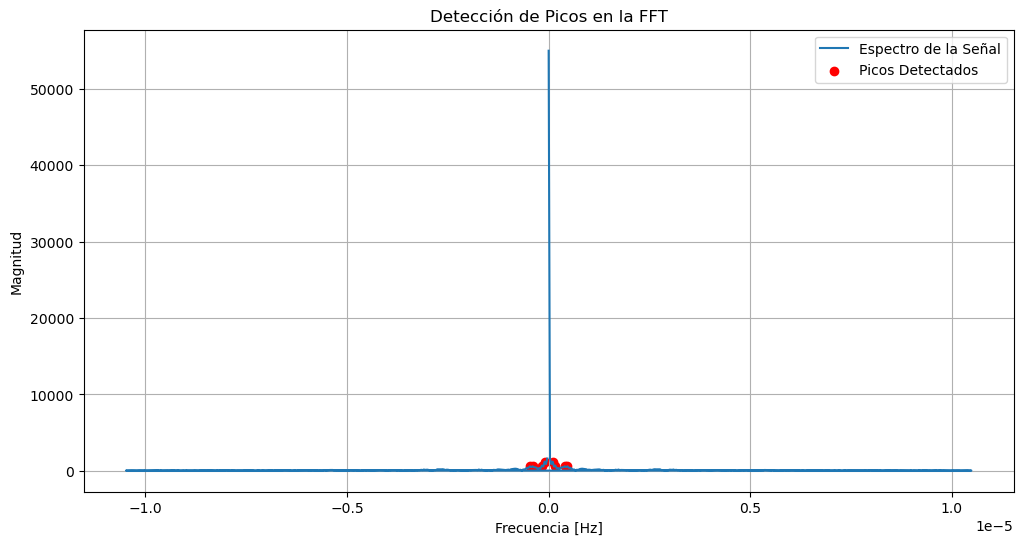

In [32]:
from scipy.signal import find_peaks

#Encontrar picos en la magnitud de la FFT y sus frecuencias correspondientes, se establece un umbral de 0.2 para detectar picos significativos
peaks, _ = find_peaks(fft_magnitude, height=0.01 * fft_magnitude.max()) #Se establece un umbral del 1% de la magnitud máxima de la FFT para detectar picos significativos
peak_frequencies = fft_frequency[peaks]
peak_magnitudes = fft_magnitude[peaks]
#Mostrar los picos detectados
print("Picos detectados:")
for freq, mag in zip(peak_frequencies, peak_magnitudes):
    print(f"Frecuencia: {freq:.2f} Hz, Magnitud: {mag:.2f}")
#Graficar la FFT y marcar los picos detectados
#Hacer más visible los picos y reducir el tamaño del espectro de la señal para visualizar mejor los picos
plt.figure(figsize=(12, 6))
plt.plot(fft_frequency, fft_magnitude, label='Espectro de la Señal')
plt.scatter(peak_frequencies, peak_magnitudes, color='red', label='Picos Detectados')
plt.title('Detección de Picos en la FFT')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud')
plt.grid()
plt.legend()
plt.show()


Número de Canales que Pueden Ser Acomodados: 3
Ancho de Banda Ocupado por las Señales Satelitales: 30.0 MHz
Número de Canales que Pueden Ser Acomodados: 150


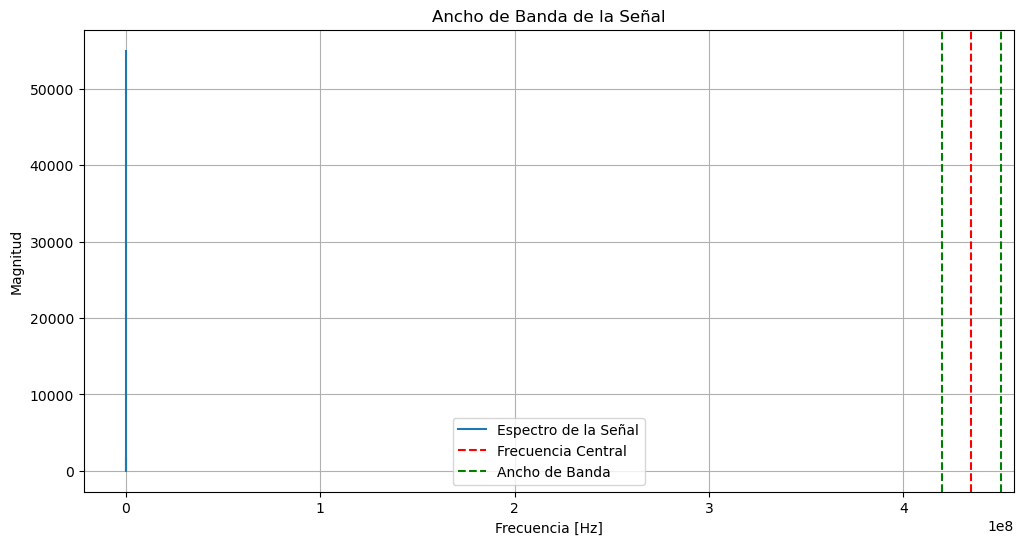

In [37]:

# Definir ancho de banda ocupado por las señales satelitales detectadas
bandwidth = 10e6  # Ancho de banda de 10 MHz para señales satelitales
# Calcular la cantidad de canales que pueden ser acomodados en el ancho de banda
num_channels = int(ancho_de_banda / bandwidth)
# Mostrar los resultados
print(f"Número de Canales que Pueden Ser Acomodados: {num_channels}")
# Definir el ancho de banda de un canal de comunicación
channel_bandwidth = 200e3  # Ancho de banda de un canal de comunicación de 200 kHz
# Calcular la cantidad de canales que pueden ser acomodados en el ancho de banda
num_channels = int(ancho_de_banda / channel_bandwidth)

# Mostrar los resultados
print(f"Ancho de Banda Ocupado por las Señales Satelitales: {ancho_de_banda / 1e6} MHz")
print(f"Número de Canales que Pueden Ser Acomodados: {num_channels}")
#Graficar ancho de banda de centrando la señal
plt.figure(figsize=(12, 6))
plt.plot(fft_frequency, fft_magnitude, label='Espectro de la Señal')
plt.axvline(frecuencia_central, color='red', linestyle='--', label='Frecuencia Central')
plt.axvline(frecuencia_central - ancho_de_banda / 2, color='green', linestyle='--', label='Ancho de Banda')
plt.axvline(frecuencia_central + ancho_de_banda / 2, color='green', linestyle='--')
plt.title('Ancho de Banda de la Señal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud')
plt.grid()
plt.legend()
plt.show()

Crest Factor: -0.59


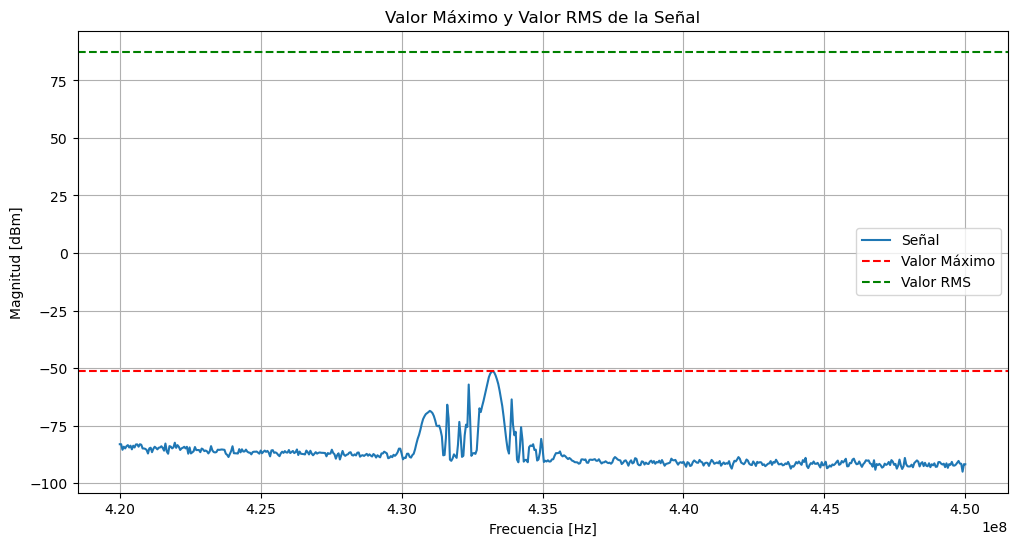

In [38]:
# Calcular el Valor Máximo
max_value = np.max(power_data)

# Calcular el Valor RMS
rms_value = np.sqrt(np.mean(power_data**2))

# Calcular el Crest Factor
crest_factor = max_value / rms_value

# Mostrar el resultado
print(f"Crest Factor: {crest_factor:.2f}")

# Graficar la señal original con el valor máximo y el valor RMS
plt.figure(figsize=(12, 6))
plt.plot(frequency_data, power_data, label='Señal')
plt.axhline(max_value, color='red', linestyle='--', label='Valor Máximo')
plt.axhline(rms_value, color='green', linestyle='--', label='Valor RMS')
plt.title('Valor Máximo y Valor RMS de la Señal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dBm]')
plt.grid()
plt.legend()
plt.show()

C:\Users\Mafe\AppData\Local\Temp\ipykernel_41176\3850179197.py:8: RuntimeWarning: Mean of empty slice.
  pulse_times_float = pulse_times.mean()
c:\Users\Mafe\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Frecuencia de Repetición de Pulso (PRF): nan Hz


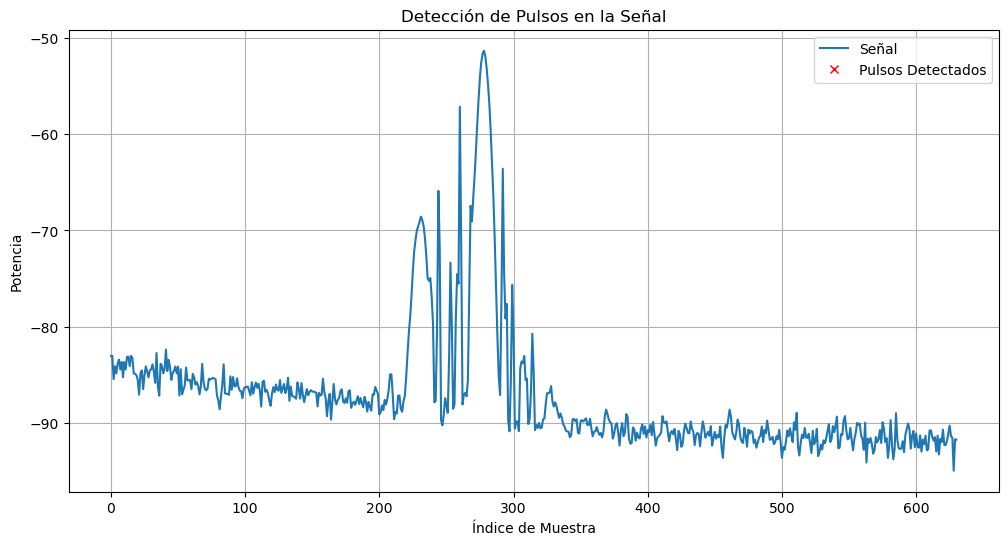

In [46]:
# Identificar picos en la señal para determinar los pulsos
peaks_indices, _ = find_peaks(power_data, height=0.01)  # Ajustar 'height' según sea necesario
peak_times = peaks_indices  # Usar los índices de los picos como tiempos

#Calcular la frecuencia de repetición de pulso de las ondas de frecuencia satelitales
# Calcular la diferencia de tiempo entre los pulsos
pulse_times = np.diff(peak_times)
pulse_times_float = pulse_times.mean()

# Mostrar el resultado
print(f"Frecuencia de Repetición de Pulso (PRF): {pulse_times_float:.2f} Hz")

# Graficar la señal original y los picos
plt.figure(figsize=(12, 6))
plt.plot(power_data, label='Señal')
plt.plot(peaks_indices, power_data[peaks_indices], "x", color='red', label='Pulsos Detectados')
plt.title('Detección de Pulsos en la Señal')
plt.xlabel('Índice de Muestra')
plt.ylabel('Potencia')
plt.legend()
plt.grid()
plt.show()

Relación Señal a Interferencia para Canal Adyacente 1: 25.98
Relación Señal a Interferencia para Canal Adyacente 2: 26.11


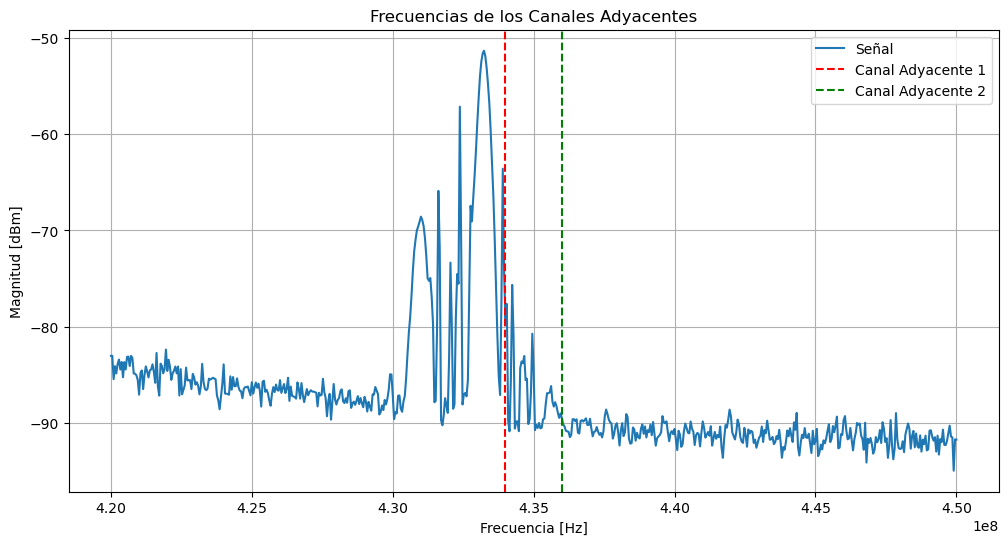

In [47]:
# Calcular la frecuencia de lso canales y la relación señal a interferencia
# Definir las frecuencias de los canales adyacentes
frecuencia_canal_adyacente_1 = 434e6  # Frecuencia del canal adyacente 1
frecuencia_canal_adyacente_2 = 436e6  # Frecuencia del canal adyacente 2

# Calcular la relación señal a interferencia
snir_1 = signal_power_rms / (noise_power_rms + np.max(power_data[frequency_data == frecuencia_canal_adyacente_1]))
snir_2 = signal_power_rms / (noise_power_rms + np.max(power_data[frequency_data == frecuencia_canal_adyacente_2]))
# Mostrar los resultados
print(f"Relación Señal a Interferencia para Canal Adyacente 1: {snir_1:.2f}")
print(f"Relación Señal a Interferencia para Canal Adyacente 2: {snir_2:.2f}")

# Calcular la relación señal a interferencia
snir_1 = signal_power_rms / (noise_power_rms + np.max(power_data[frequency_data == frecuencia_canal_adyacente_1]))
snir_2 = signal_power_rms / (noise_power_rms + np.max(power_data[frequency_data == frecuencia_canal_adyacente_2]))
#Graficar la señal original con las frecuencias de los canales adyacentes
plt.figure(figsize=(12, 6))
plt.plot(frequency_data, power_data, label='Señal')
plt.axvline(frecuencia_canal_adyacente_1, color='red', linestyle='--', label='Canal Adyacente 1')
plt.axvline(frecuencia_canal_adyacente_2, color='green', linestyle='--', label='Canal Adyacente 2')
plt.title('Frecuencias de los Canales Adyacentes')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dBm]')
plt.grid()
plt.legend()
plt.show()

Drift de Frecuencia: 47619.05 Hz/s


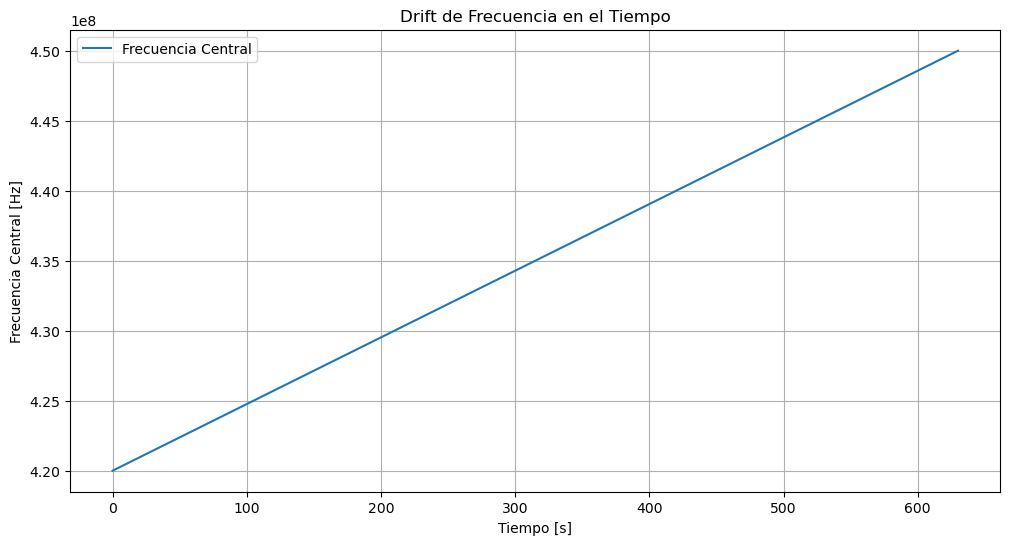

In [49]:
#Calcular drift de frecuencia para las señales satelitales, como el cambio en la frecuencia central de la señal a lo largo del tiempo.
# Definir el tiempo en segundos
tiempo = np.arange(0, len(power_data))  # Tiempo en segundos

# Calcular la pendiente de la frecuencia central
slope, intercept = np.polyfit(tiempo, frequency_data, 1)

# Mostrar el resultado
print(f"Drift de Frecuencia: {slope:.2f} Hz/s")
# Graficar la señal original y la frecuencia central
plt.figure(figsize=(12, 6))
plt.plot(tiempo, frequency_data, label='Frecuencia Central')
plt.title('Drift de Frecuencia en el Tiempo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia Central [Hz]')
plt.grid()
plt.legend()
plt.show()


In [50]:
#Definir tiempo de ocupación de canal para señales satelitales
# Calcular el tiempo de ocupación del canal
tiempo_ocupacion_canal = ancho_de_banda / bandwidth  # Tiempo de ocupación del canal en segundos

# Mostrar el resultado
print(f"Tiempo de Ocupación del Canal: {tiempo_ocupacion_canal:.2f} s")

# Calcular el tiempo de ocupación del canal
tiempo_ocupacion_canal = ancho_de_banda / channel_bandwidth  # Tiempo de ocupación del canal en segundos


Tiempo de Ocupación del Canal: 3.00 s


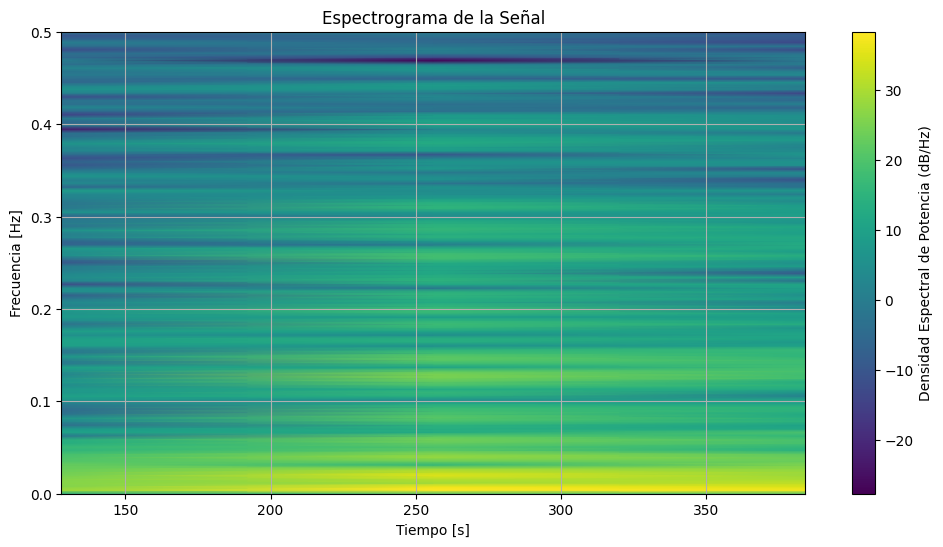

In [46]:
from scipy.signal import spectrogram

# Definir parámetros para el análisis de espectro temporal
fs = 1.0  # Frecuencia de muestreo (ajustar según tus datos)
nperseg = 256  # Número de puntos por segmento (ajustar según sea necesario)
noverlap = 128  # Número de puntos de solapamiento (ajustar según sea necesario)

# Calcular el espectrograma
frequencies, times, Sxx = spectrogram(power_data, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Graficar el espectrograma
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Densidad Espectral de Potencia (dB/Hz)')
plt.title('Espectrograma de la Señal')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.ylim(0, 0.5 * fs)  # Ajustar el límite superior según la frecuencia de interés
plt.grid()
plt.show()

Potencia de Canal Ocupado: -87.19 dBm


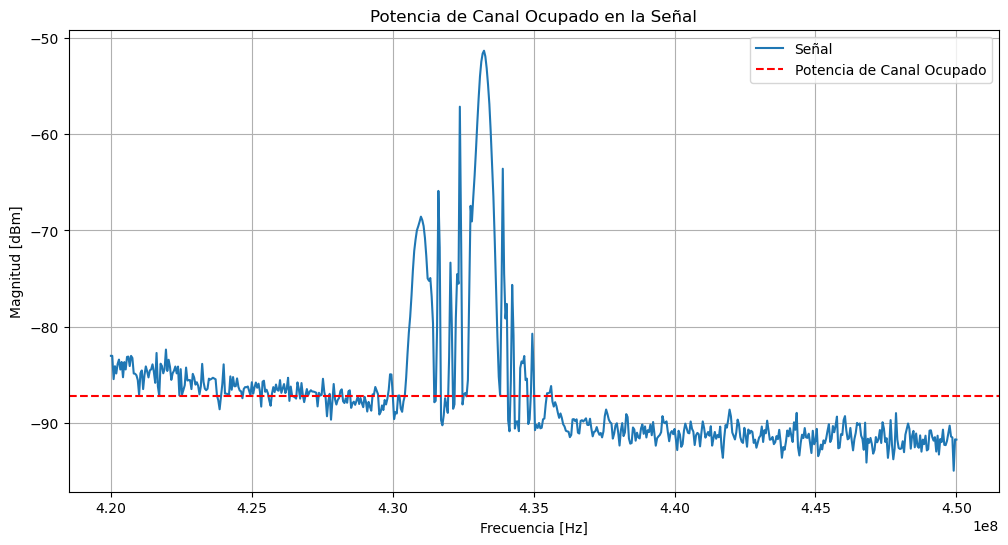

In [51]:
#Definir la medición de potencia de canal ocupado para señales satelitales
# Calcular la potencia de canal ocupado
potencia_canal_ocupado = np.sum(power_data) / len(power_data)  # Potencia de canal ocupado en dBm

# Mostrar el resultado
print(f"Potencia de Canal Ocupado: {potencia_canal_ocupado:.2f} dBm")
#Gráfica de la señal original con la potencia de canal ocupado
plt.figure(figsize=(12, 6))
plt.plot(frequency_data, power_data, label='Señal')
plt.axhline(potencia_canal_ocupado, color='red', linestyle='--', label='Potencia de Canal Ocupado')
plt.title('Potencia de Canal Ocupado en la Señal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dBm]')
plt.grid()
plt.legend()
plt.show()